In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython import display
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
from metrics import anderson_darling, kendall_error

# Import data

In [3]:
data = pd.read_csv("./data_train_log_return.csv", header=None).drop(columns=[0])
data.columns = [f'index{i}' for i in range(1, 5)]
data

,index1,index2,index3,index4
0,0.012495,0.011126,0.003252,0.006625
1,0.011439,0.002691,0.001206,0.006947
2,0.000632,0.007277,0.004049,0.000074
3,0.017828,0.028210,0.007758,0.007382
4,0.021115,0.019642,0.009238,0.011499
...,...,...,...,...
741,0.001938,0.008833,0.003927,0.005106
742,0.005003,0.018943,0.003057,0.001988
743,0.007683,0.001958,0.007002,0.006467
744,0.003396,0.001280,0.007621,0.001680


In [4]:
data = data.values

# VAE

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [6]:
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.15.0
Eager mode:  True
GPU is NOT AVAILABLE


### Create the model

In [7]:
class VAE(tf.keras.Model):

    def __init__(self, latent_dim, input_dim=data.shape[1]):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(input_dim,)),
                tf.keras.layers.Dense(128, activation='relu'),
                tf.keras.layers.Dense(64, activation='relu'),
                # No activation
                tf.keras.layers.Dense(latent_dim + latent_dim),
            ]
        )

        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                tf.keras.layers.Dense(128, activation='relu'),
                tf.keras.layers.Dense(64, activation='relu'),
                # No activation
                tf.keras.layers.Dense(input_dim)
            ]
        )

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [8]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(-.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi), axis=raxis)


def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent)
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
    """Executes one training step and returns the loss.

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [9]:
def generate_samples(model, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    return predictions

### Training

In [10]:
X_train, X_test = train_test_split(data)
X_train, X_test = tf.cast(X_train, dtype=tf.float32), tf.cast(X_test, dtype=tf.float32)

In [11]:
def histogram(ax, data, label=""):
    sns.histplot(data, kde=True, ax=ax, stat='density', label=label)
    ax.legend()
    ax.set_ylabel('')
    ax.set_xlabel('')

def plot_distribution(model, test_sample):
    generated_sample = generate_samples(model, test_sample)
    fig, axs = plt.subplots(4, 2, figsize=(8, 8))
    for i in range(4):
        histogram(axs[i][0], data[:, i], label=f'True index{i+1}')
        histogram(axs[i][1], generated_sample[:, i], label=f'Gen index{i+1}')
    for ax in axs:
        for ax_i in ax:
            ax_i.legend()

    plt.tight_layout()
    plt.show()
    return generated_sample

def plot_distribution_errors(model, test_sample, errors):
    generated_sample = generate_samples(model, test_sample)
    fig, axs = plt.subplots(4, 3, figsize=(14, 8))
    for i in range(4):
        histogram(axs[i][0], data[:, i], label=f'True index{i+1}')
        histogram(axs[i][1], generated_sample[:, i], label=f'Gen index{i+1}')

    #axs[0][2].plot(errors['train_elbo'], label='Train ELBO')
    axs[0][2].plot(errors['test_elbo'], label='Test ELBO')
    axs[0][2].grid('on')

    axs[1][2].plot(errors['random_anderson'][-10:], label='Random noise Anderson')
    axs[1][2].grid('on')

    axs[2][2].plot(errors['random_kendall'], label='Random noise Kendall')
    axs[2][2].grid('on')

    axs[3][2].axis('off')

    for i, ax in enumerate(axs):
        for j, ax_j in enumerate(ax):
            if not (i == 3 and j == 2):
                ax_j.legend()

    plt.tight_layout()
    plt.show()
    return generated_sample

In [12]:
latent_dim = 3
model = VAE(latent_dim)

optimizer = tf.keras.optimizers.Adam(1e-4)
loss = tf.keras.metrics.Mean()

In [13]:
def compute_metrics(model, X_train, X_test, errors):
    random_noise = np.random.exponential(2e-2, size=(data.shape))
    generated_sample = generate_samples(model, random_noise)

    random_anderson = anderson_darling(data, generated_sample.numpy())

    random_kendall = kendall_error(data, generated_sample.numpy())

    errors['random_anderson'].append(random_anderson)
    errors['random_kendall'].append(random_kendall)

In [14]:
errors = {}
errors['test_elbo'] = []
errors['random_anderson'] = []
errors['random_kendall'] = []

Patience! Epoch: 350654, ELBO: -47.956947326660156


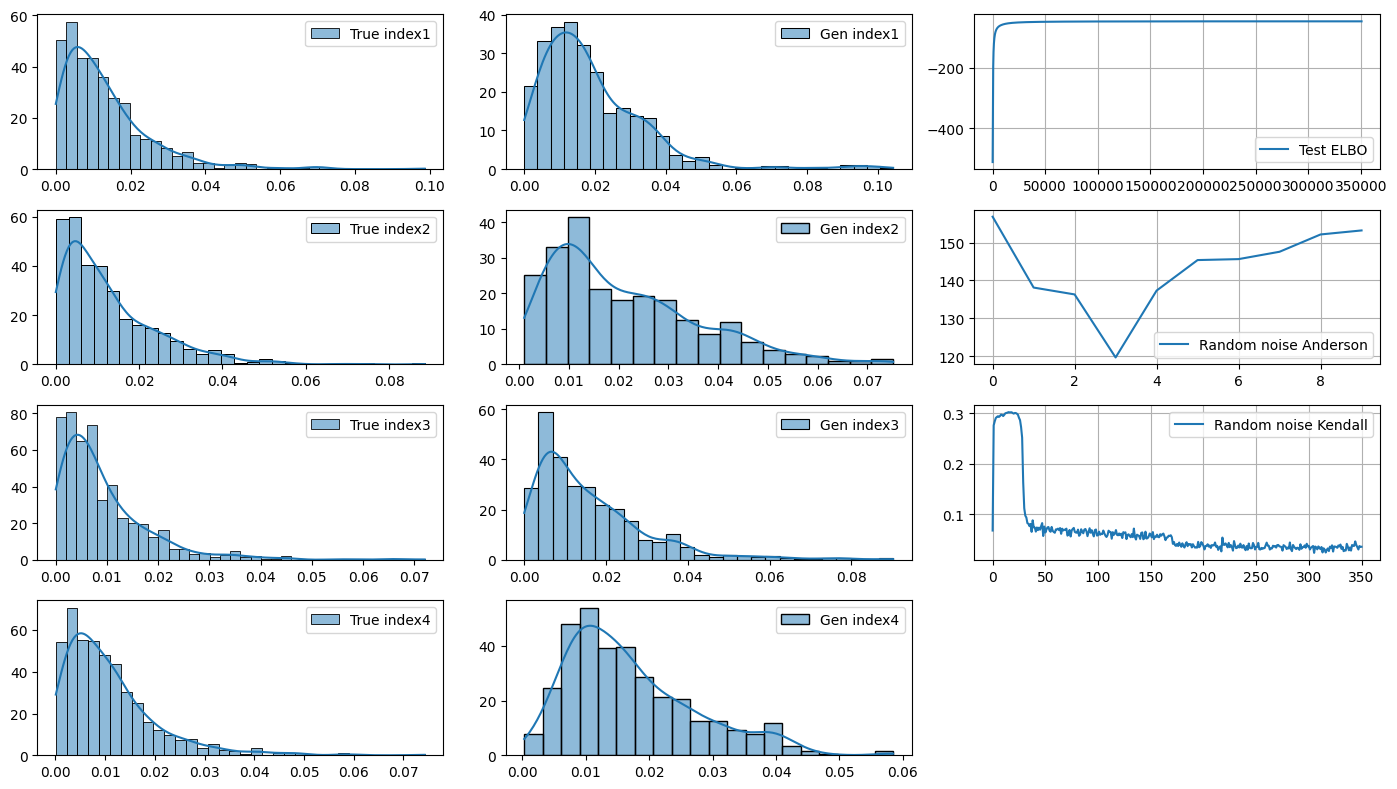

In [15]:
epochs = 500_000
display_every = 1000
patience = 1000
best_elbo = float('-inf')
no_improvement_count = 0

start_time = time.time()
for epoch in range(1, epochs + 1):
    train_step(model, X_train, optimizer)

    loss(compute_loss(model, X_test))
    elbo = -loss.result()
    errors['test_elbo'].append(elbo)

    # check for patience
    if elbo > best_elbo:
        best_elbo = elbo
        no_improvement_count = 0  # reset the counter
    else:
        no_improvement_count += 1

    if no_improvement_count >= patience:
        display.clear_output(wait=False)
        print(f'Patience! Epoch: {epoch}, ELBO: {elbo}')
        #plot_distribution_errors(model, X_test, errors)
        random_noise = np.random.exponential(2e-2, size=(data.shape))
        plot_distribution_errors(model, random_noise, errors)
        break

    if epoch % display_every == 0 or epoch == 1:
        display.clear_output(wait=False)
        compute_metrics(model, X_train, X_test, errors)
        end_time = time.time()
        print(f"Epoch: {epoch}, ELBO: {elbo}, time: {round(end_time-start_time, 4)}s for {display_every} epochs")
        start_time = time.time()
        #plot_distribution_errors(model, X_test, errors)
        random_noise = np.random.exponential(2e-2, size=(data.shape))
        plot_distribution_errors(model, random_noise, errors)

In [16]:
model.save_weights("./")

### Generate new data

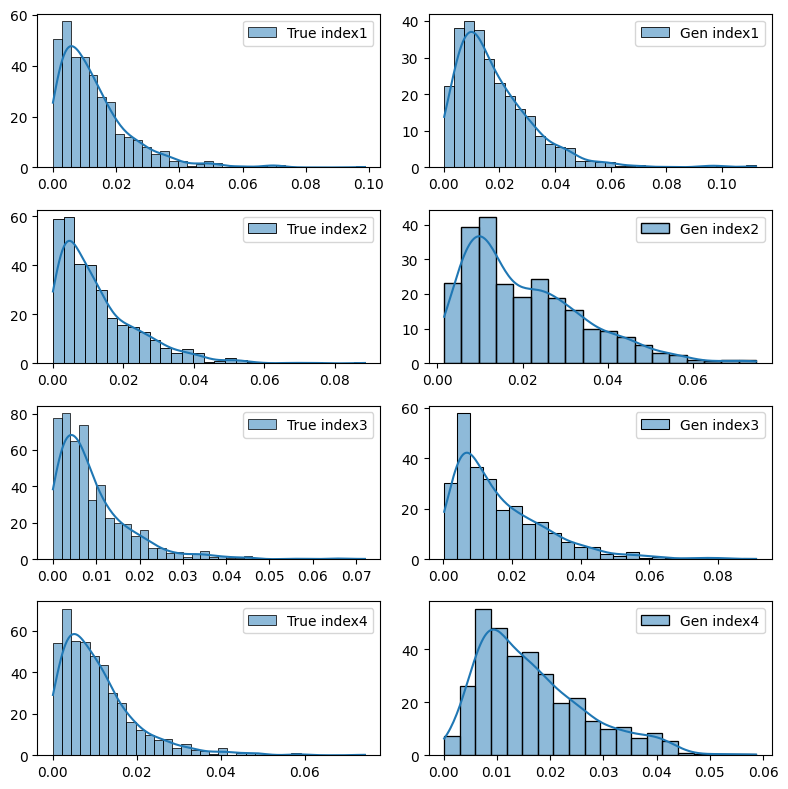

In [17]:
n_gen = 1000
#random_noise = np.random.normal(size=(n_gen, 4))
random_noise = np.random.exponential(2e-2, size=(data.shape))
generated_sample = plot_distribution(model, random_noise)

In [18]:
anderson_darling(data, generated_sample.numpy())

143.0462562227885

In [19]:
kendall_error(data, generated_sample.numpy())

0.035390539251848784